In [1]:
%pylab inline
from scipy.interpolate import interp1d
import scipy as sc

Populating the interactive namespace from numpy and matplotlib


In [2]:
e = 1  # onsite energy
t = 1 # hopping
U = 1 # coulob repulsion
ne = 1.4 # number of electrons per unit cell/ occupation number
T = 1 # tempreture
n1 = 1 #occupation on site 1
n2 = 1 #occupation on site 1
sigma=0.02
delta=0.1

In [3]:
# LASZLO:
# This is roughly ok but I think we can speed part up with some carefull organization
# mainly due to the fact that if we calculate gamma once we can keep it in memory
# since that part of the Hamiltonian does not change troughout the whole scf procedure
# also we could get rid of for loops.. 

def hamiltonian(U,n1,n2,kxran=linspace(-pi,pi,200,endpoint=False),
                        kyran=linspace(-pi,pi,200,endpoint=False)):
    eigenval=[]
    eigenvec=[]
    for kx in kxran:
        for ky in kyran:
            gamma = 1+exp(-1j*2*kx)+exp(-1j*(kx+ky))+exp(-1j*(kx-ky))
            H = array([[U*n1           ,-1*gamma],
                       [-1*conj(gamma),U*n2     ]])
            w,v =eigh(H)
            eigenval.append(w)
            eigenvec.append(v)
    return array(eigenval),array(eigenvec)

In [4]:
# LASZLO:
# This seems ok at the moent, but this might not scale well in terms of numer of k-point..
# We should revisit this later on..
def densty(E,sigma=0.02):
    return sum(1/(sigma*sqrt(2*pi))*exp(-((E-hamiltonian(U,n1,n2)[0].flatten())/sigma)**2/2))

In [5]:
# LASZLO:
# again this is good for the moment.. but we might need to readjust it depending on how the scf cycle converges..
def get_chemical_pot(ne): # ne: number of electrons per unit cell
    NE,eran,_=hist(hamiltonian(U,n1,n2)[0].flatten(),linspace(-6,6,200),cumulative=True,density=True)
    mu= interp1d(NE,eran[:-1])
    return mu(ne)

In [6]:
# LASZLO:
# I think we hawe written this together
def num_of_electron_MKII(mu,site,kbt=0.01,use_Fermi=False):
    if use_Fermi:
        avg_num_of_elec = (\
        sum(abs(vects[:,site,0])**2*fermi(vals[:,0]-mu,kbt=kbt))+\
        sum(abs(vects[:,site,1])**2*fermi(vals[:,1]-mu,kbt=kbt)))/num_of_eigen_val
    else:
        avg_num_of_elec = \
        (sum(abs(vects[vals[:,0]<mu,site,0])**2)+\
         sum(abs(vects[vals[:,1]<mu,site,1])**2))/num_of_eigen_val # len hamiltonian 0]
    return avg_num_of_elec

In [7]:
h= hamiltonian(U,n1,n2)

In [8]:
h[0]

array([[-3.        ,  5.        ],
       [-2.99901312,  4.99901312],
       [-2.99605346,  4.99605346],
       ...,
       [-2.99013705,  4.99013705],
       [-2.99506658,  4.99506658],
       [-2.99802624,  4.99802624]])

In [4]:
def gg (U,ne):
    discrepancy = 10

    n1_up,n2_up = ne/4+delta,ne/4-delta
    #n1_do,n2_do = ne/2-delta,ne/2+delta #AFM
    n1_do,n2_do = ne/4+delta,ne/4-delta  #FM
    while discrepancy >= 10**-5:

        vals_up,vects_up = hamiltonian(U,n1_do,n2_do)
        vals_do,vects_do = hamiltonian(U,n1_up,n2_up)
        
        # FIX THE STUF DOWN FROM HERE
        num_of_eigen_val = len(vals_up)
        # LASZLO this is not good!
        # There is a single chemical potential in the system, 
        # NE_up,eran_up,_= hist(vals_up.flatten(),linspace(-6,6,200),cumulative=True,density=True)
        # mu_up = interp1d(NE_up,eran_up[:-1],fill_value="extrapolate")
        
        # NE_do,eran_do,_= hist(vals_do.flatten(),linspace(-6,6,200),cumulative=True,density=True)
        # mu_do = interp1d(NE_do,eran_up[:-1],fill_value="extrapolate")
        # you have to do something along the line 
        NE,eran,_= hist(array([vals_up,vals_do]).flatten(),linspace(-6,6,200),cumulative=True,density=True)
        mu = interp1d(NE,eran[:-1],fill_value="extrapolate") # We need 
        # Here we only need mu
        n1_do_new = sum(abs(vects_do[vals_do[:,0]<mu(ne),0,0])**2)/num_of_eigen_val 
        n2_do_new = sum(abs(vects_do[vals_do[:,1]<mu(ne),1,1])**2)/num_of_eigen_val 
        n1_up_new = sum(abs(vects_up[vals_up[:,1]<mu(ne),0,1])**2)/num_of_eigen_val
        n2_up_new = sum(abs(vects_up[vals_up[:,1]<mu(ne),1,0])**2)/num_of_eigen_val

        # LASZLO
        # All the above stuff inside the while loop should be packaged into a separate function!
        #

        
        n1_up,n2_up = n1_up_new,n2_up_new
        n1_do,n2_do = n1_do_new,n2_do_new

        
        # LASZLO
        # we need to see if this is a good measure for disrepancy
        # there might be some other measures
        discrepancy = sqrt((n1_up_new-n1_up)**2+
                           (n2_up_new-n2_up)**2+
                           (n1_do_new-n1_do)**2+
                           (n2_do_new-n2_do)**2 )
        
    # This is not the energy we should calculate! 
    # why are here 4 contributions ?
    E1_up = sum(vals_up[:,0])
    E2_up = sum(vals_up[:,1])
    E1_do = sum(vals_do[:,0])
    E2_do = sum(vals_do[:,1])
    return(E1_up,E2_up,E1_do,E2_do)

In [10]:
#class HubbardModel():
    
 #   def __init__(self,on_site_energy,coulomb_repulsion,number_of_electrons_per_unit_cell):
        
  #      self.on_site_energy=on_site_energy
   #     self.coulomb_repulsion=coulomb_repulsion
    #    self.number_of_electrons_per_unit_cell
    

/home/oroszll1/miniconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


(-49246.192892237275,
 81246.19289223728,
 -49246.192892237275,
 81246.19289223728)

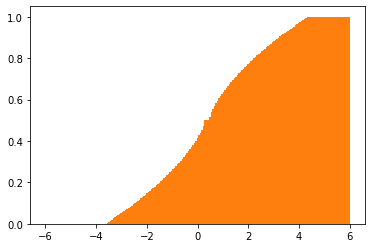

In [11]:
gg(1,1.6)